This post was originally going to focus on using multivariate linear regression to model hourly, regional electricity load data until I noticed that some of the series that I was importing from EIA appeared to be contaminated with outliers and missing data. I started to spend a considerable amount of time scrubbing the data and decided to just turn the scrubbing exercise into its own post. Data scrubbing is not always the most rewarding task but I tried to put an interesting spin on this by playing around with an unsupervised machine learning technique that can be used for outlier detection. The goal is to come up with a method that would dynamically identify outliers on the fly.

In [1]:
import sys
sys.path.insert(0, '/home/johnr_000/jupyter_blog/jupyter_blog/scripts')
import eia_model as em
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from datetime import datetime

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
#variables to specify date range and frequency
api_key = em.eia_api
start = '2015-12-01 01:00:00'
end = '2016-01-31 23:00:00'
freq = 'H'
# create list of series used for dictionary keys
keys = ['EBA.BPAT-ALL.D.H', 'EBA.PACE-ALL.D.H', 'EBA.PACW-ALL.D.H', 
        'EBA.PGE-ALL.D.H', 'EBA.PSEI-ALL.D.H', 'EBA.SCL-ALL.D.H']
# create dict of GetSeriesRange objects from series list
# series_dict = {key: em.GetSeries(api_key=api_key, series_id=key, 
#                                    start=start, end=end, freq=freq) for key in keys}

In [ ]:
# loop over dictionary and print out full name of each series
for key in series_dict:
    print('{}: {}'.format(series_dict[key].data.series[0]['name'],key))

In [21]:
# all the dataframes have the same date range so we can concatenate in a loop
concat_df = pd.concat([series_dict[key].data.df for key in series_dict], axis=1)
# and output as a pickle file - I'm doing this to avoid calling the EIA API as I develop
concat_df.to_pickle('data/nw_load_df.pkl')
# concat_df = pd.read_pickle('data/new_load_df.pkl')

In [4]:
concat_df = pd.read_pickle('/home/johnr_000/jupyter_blog/jupyter_blog/data/nw_load_df.pkl')

In [5]:
# print out descriptive statistics for each series
for key in keys:
    print(key,
          "'\t\n mean :'{}".format(concat_df[key].mean()),
          "' median :'{}".format(concat_df[key].median()),
          "' min :'{}".format(concat_df[key].min()),
          "' max :'{}".format(concat_df[key].max())
          )

EBA.BPAT-ALL.D.H '	
 mean :'7059.477471418964 ' median :'7109.0 ' min :'5006 ' max :'9365
EBA.PACE-ALL.D.H '	
 mean :'-24706.174848688635 ' median :'5508.0 ' min :'-31990166 ' max :'59668
EBA.PACW-ALL.D.H '	
 mean :'4451.197713517148 ' median :'2709.0 ' min :'-6785 ' max :'2530003
EBA.PGE-ALL.D.H '	
 mean :'2579.9219905850705 ' median :'2646.0 ' min :'1730 ' max :'3472
EBA.PSEI-ALL.D.H '	
 mean :'3946.0661268556005 ' median :'4021.0 ' min :'2292.0 ' max :'5088.0
EBA.SCL-ALL.D.H '	
 mean :'1282.2589105581708 ' median :'1324.0 ' min :'868 ' max :'1654


In [6]:
# first pass filter out negatives and zeroes
for key in keys:
    concat_df[concat_df[key] < 0] = np.nan

for key in keys:
    print(key,
          "'\t\n mean :'{}".format(concat_df[key].mean()),
          "' median :'{}".format(concat_df[key].median()),
          "' min :'{}".format(concat_df[key].min()),
          "' max :'{}".format(concat_df[key].max())
          )

EBA.BPAT-ALL.D.H '	
 mean :'7057.380823767725 ' median :'7107.0 ' min :'5006.0 ' max :'9365.0
EBA.PACE-ALL.D.H '	
 mean :'5532.663065496286 ' median :'5508.0 ' min :'4108.0 ' max :'59668.0
EBA.PACW-ALL.D.H '	
 mean :'4478.549628629305 ' median :'2710.0 ' min :'1763.0 ' max :'2530003.0
EBA.PGE-ALL.D.H '	
 mean :'2578.5563808237675 ' median :'2643.0 ' min :'1730.0 ' max :'3472.0
EBA.PSEI-ALL.D.H '	
 mean :'3944.419376693767 ' median :'4017.5 ' min :'2292.0 ' max :'5088.0
EBA.SCL-ALL.D.H '	
 mean :'1281.6914247130317 ' median :'1322.0 ' min :'868.0 ' max :'1654.0


In [7]:
concat_df['HOUR'] = concat_df.index.to_datetime().hour

In [8]:
class PredictOutliers(object):
    
    def __init__(self, series_id, train_df, cont):
        self.series_id = series_id
        self.train_df = train_df[['HOUR', self.series_id]].interpolate(method= 'linear')
        self.training_data = self.train_df[['HOUR', self.series_id]].values
        self.clf = self.fit_clf(cont)
        self.pred_df = pd.concat([self.train_df, self.create_predictions()], axis=1)
        
    def fit_clf(self, cont):
        clf = IsolationForest(contamination=cont)
        return clf.fit(self.training_data)
        
    def create_predictions(self):
        opred = self.clf.predict(self.training_data)
        dfunc = self.clf.decision_function(self.training_data)
        l1 = '{}{}'.format(self.series_id, '_opred')
        l2 = '{}{}'.format(self.series_id, '_dfunc')
        return pd.DataFrame(np.column_stack((opred, dfunc)), index=self.train_df.index.values, columns=[l1, l2])

In [9]:
pred_dict = {key: PredictOutliers(key, concat_df, .01) for key in keys}

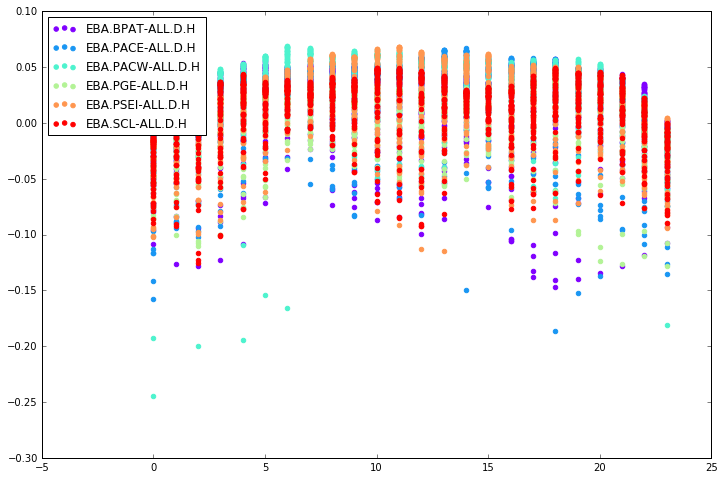

In [10]:
fig = plt.figure(figsize=(12, 8), dpi=100)
colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))
for key, color in zip(keys, colors):
    pred_df = pred_dict[key].pred_df
    plt.scatter(pred_df['HOUR'].values, pred_df['{}{}'.format(key, '_dfunc')].values, 
                color=color, label=key)
legend = plt.legend(loc='upper left')
plt.show()

In [20]:
for key in keys:
    pred_df = pred_dict[key].pred_df
    print(key + ': \n',
          pred_df[pred_df[key + '_opred'] == -1][[key,key + '_dfunc']].sort_values(by = key + '_dfunc')
          )

EBA.BPAT-ALL.D.H: 
                      EBA.BPAT-ALL.D.H  EBA.BPAT-ALL.D.H_dfunc
2016-01-03 18:00:00          9365.000                  -0.147
2016-01-02 18:00:00          9298.000                  -0.141
2016-01-03 19:00:00          9266.000                  -0.140
2016-01-02 17:00:00          9284.000                  -0.138
2016-01-03 20:00:00          9148.000                  -0.134
2016-01-03 17:00:00          9256.000                  -0.133
2016-01-04 02:00:00          9267.000                  -0.128
2016-01-03 21:00:00          8971.000                  -0.128
2016-01-04 01:00:00          8981.000                  -0.126
2016-01-04 03:00:00          9152.000                  -0.123
2016-01-02 19:00:00          9016.000                  -0.123
2015-12-31 17:00:00          9075.000                  -0.119
2016-01-03 22:00:00          8807.000                  -0.118
2015-12-31 18:00:00          8991.000                  -0.116
2016-01-04 17:00:00          8941.000             

In [21]:
# first pass filter out negatives and zeroes
for key in keys:
    pred_df = pred_dict[key].pred_df
    pred_df[pred_df[key + '_dfunc'] < 0.18] = np.nan